In [122]:
import pickle
import numpy as np
suffix = '_solar'
suffix_str = 'solar'
target = pickle.load(open(f'_target{suffix}.pkl', 'rb'))

import matplotlib.pyplot as plt
# 设置全局字号
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 15

In [123]:
sub_target = target[-1][-24*7:]
print(sub_target.shape) # (168,370*5)
targets_num = 5
# 在纬度1上按照370个进行切分，得到5个子序列
targets = np.split(sub_target, 5, axis=1)
print(targets[0].shape) # (168,370)

dim_index = 30
targets_dim = [np.array(target)[:,dim_index] for target in targets]
print(targets_dim[0].shape) # (168,)

# targets_dim = [targets_dim[0], targets_dim[1], targets_dim[2], targets_dim[3], targets_dim[4]]
# targets_dim = [targets_dim[2], targets_dim[3]]
# targets_dim = [targets_dim[0], targets_dim[2], targets_dim[4]]

target_gran = [0,1,2,3,4]
gran_name = ['1h','4h','6h','12h','24h']

(168, 1850)
(168, 370)
(168,)


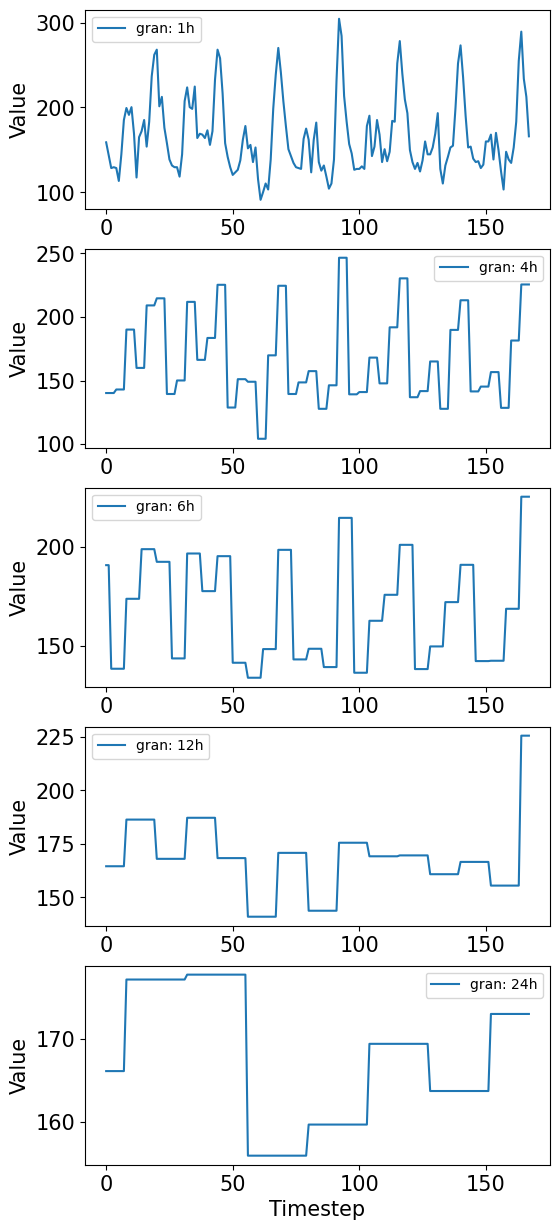

In [124]:
def draw(targets_dim, target_gran, gran_name):
    import matplotlib.pyplot as plt
    # plt.figure(figsize=(6, 5))
    fig,axes = plt.subplots(len(targets_dim),1 , figsize=(6, 15))
    targets_num = len(targets_dim)
    for i in target_gran:
        # plt.subplot(1, targets_num, i+1)
        ax = axes[i]
        ax.plot(targets_dim[i], label=f'gran: {gran_name[i]}')
        # ax.title('dim: {}'.format(i))
        ax.legend(fontsize=10)
        # ax.set_xlabel('Timestep')
        ax.set_ylabel('Value')
        if i == 4:
            ax.set_xlabel('Timestep')
    # plt.legend()
    # plt.show()
    plt.savefig(f'./{suffix_str}_avg_time.pdf', bbox_inches='tight')
draw(targets_dim, target_gran, gran_name)

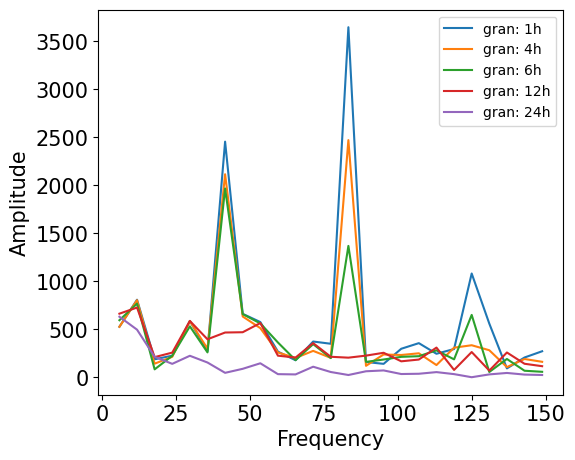

In [125]:
def draw_fft(targets_dim, target_gran, gran_name):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 5))
    for i in target_gran:
        # plt.subplot(1, targets_num, i+1)
        fs = 1000
        ft_result = np.fft.fft(targets_dim[i])
        freq = np.fft.fftfreq(len(targets_dim[i]), 1/fs)
        # 只保留freq > 0且小于150的部分
        
        ft_result = ft_result[(freq > 0) & (freq < 150)]
        freq = freq[(freq > 0) & (freq < 150)]
        plt.plot(freq, np.abs(ft_result), label=f'gran: {gran_name[i]}')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend(fontsize=10)
    # plt.show()
    plt.savefig(f'{suffix_str}_avg_fft.pdf', bbox_inches='tight')
draw_fft(targets_dim, target_gran, gran_name)

In [126]:
# dim_index = 30
# sub_target_fine = sub_target_fine[:, dim_index]
# sub_target_coarse = sub_target_coarse[:, dim_index]
# print(sub_target_fine.shape, sub_target_coarse.shape)

In [127]:
# def draw(sub_target_fine, sub_target_coarse, dim_index):
#     import matplotlib.pyplot as plt
#     plt.figure(figsize=(6, 5))
#     plt.plot(sub_target_fine, label='fine')
#     plt.plot(sub_target_coarse, label='coarse')
#     plt.legend()
#     plt.title('dim_index: {}'.format(dim_index))
#     plt.show()

# draw(sub_target_fine, sub_target_coarse, dim_index)

In [128]:
beta_end = 0.1
diff_steps = 100
betas = np.linspace(1e-4, beta_end, diff_steps)
print(betas)


[0.0001     0.00110909 0.00211818 0.00312727 0.00413636 0.00514545
 0.00615455 0.00716364 0.00817273 0.00918182 0.01019091 0.0112
 0.01220909 0.01321818 0.01422727 0.01523636 0.01624545 0.01725455
 0.01826364 0.01927273 0.02028182 0.02129091 0.0223     0.02330909
 0.02431818 0.02532727 0.02633636 0.02734545 0.02835455 0.02936364
 0.03037273 0.03138182 0.03239091 0.0334     0.03440909 0.03541818
 0.03642727 0.03743636 0.03844545 0.03945455 0.04046364 0.04147273
 0.04248182 0.04349091 0.0445     0.04550909 0.04651818 0.04752727
 0.04853636 0.04954545 0.05055455 0.05156364 0.05257273 0.05358182
 0.05459091 0.0556     0.05660909 0.05761818 0.05862727 0.05963636
 0.06064545 0.06165455 0.06266364 0.06367273 0.06468182 0.06569091
 0.0667     0.06770909 0.06871818 0.06972727 0.07073636 0.07174545
 0.07275455 0.07376364 0.07477273 0.07578182 0.07679091 0.0778
 0.07880909 0.07981818 0.08082727 0.08183636 0.08284545 0.08385455
 0.08486364 0.08587273 0.08688182 0.08789091 0.0889     0.08990909
 0.

In [129]:
import torch
import numpy as np
import copy
from functools import partial
from inspect import isfunction

to_torch = partial(torch.tensor, dtype=torch.float32)
def default(val, d):
    if val is not None:
        return val
    return d() if isfunction(d) else d
def extract(a, t, x_shape):
    b, *_ = t.shape
    # print(f'a.shape: {a.shape}')
    # print(f't.shape: {t.shape}')
    out = a.gather(-1, t)
    # print(f'out.shape: {out.shape}')
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def q_sample(x_start, t, share_ratio: float, params_dict, noise=None):
    # print(f'x_start.shape: {x_start.shape}')
    # print(f't.shape: {t.shape}')
    noise = default(noise, lambda: torch.randn_like(x_start))
    # print(noise.shape)
    suffix = int(share_ratio * 100)
    return (
        extract(params_dict[f'sqrt_alphas_cumprod_{suffix}'], t, x_start.shape) * x_start
        + extract(params_dict[f'sqrt_one_minus_alphas_cumprod_{suffix}'], t, x_start.shape) * noise
    )

share_ratios = [1.0]
params_dict = {}
for cur_share_ratio in share_ratios:
    start_index = int(len(betas)*(1-cur_share_ratio))
    betas_sub=copy.deepcopy(betas)
    betas_sub[:start_index]=0 #share the latter part of the betas 
    alphas_sub = 1.0 - betas_sub
    alphas_cumprod_sub = np.cumprod(alphas_sub, axis=0)
    alphas_cumprod_prev_sub = np.append(1.0, alphas_cumprod_sub[:-1])
    suffix = int(cur_share_ratio * 100)
    params_dict[f"sqrt_alphas_cumprod_{suffix}"] = to_torch(np.sqrt(alphas_cumprod_sub))
    params_dict[f"sqrt_one_minus_alphas_cumprod_{suffix}"] = to_torch(np.sqrt(1.0 - alphas_cumprod_sub))


res = q_sample(to_torch(targets_dim[0]), torch.tensor([10]), 1.0, params_dict)

(168,)
(168,)
(168,)
(168,)
(168,)


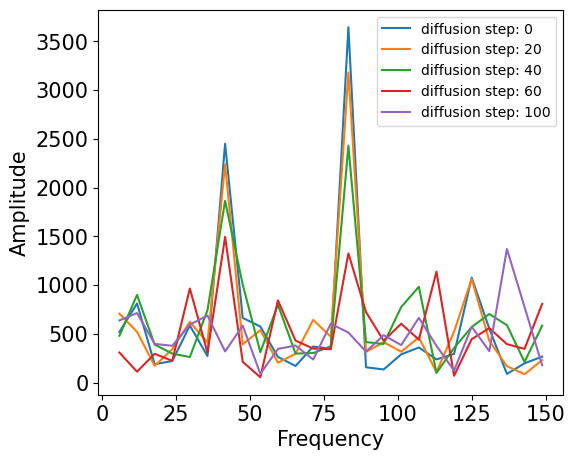

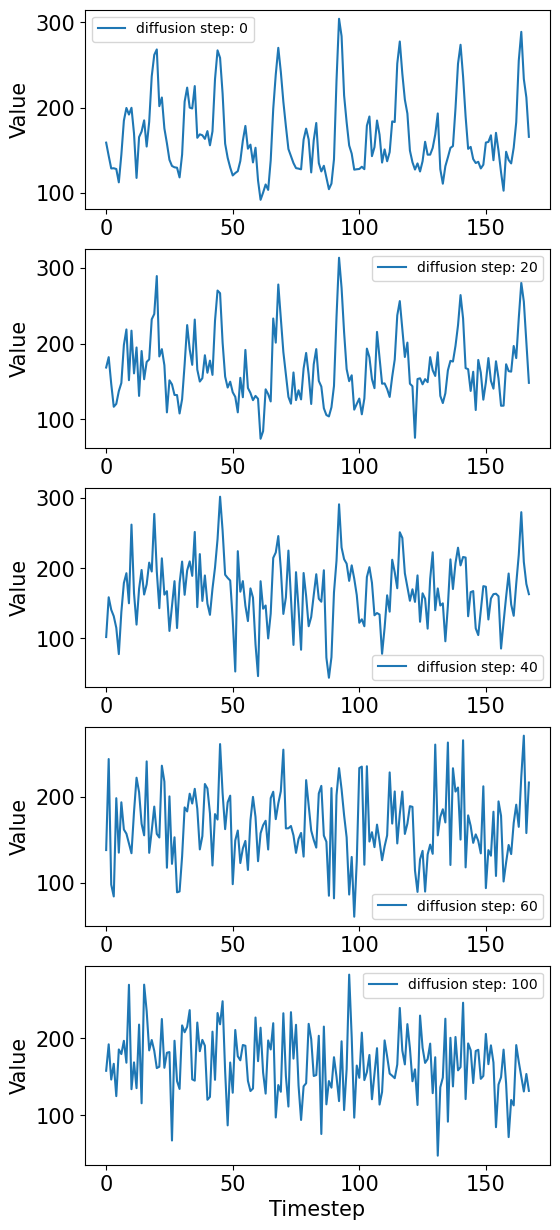

In [130]:
def draw_fft_diff(targets_diff):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 5))
    for key, value in targets_diff.items():
        fs = 1000
        ft_result = np.fft.fft(value)
        freq = np.fft.fftfreq(len(value), 1/fs)
        # 只保留freq在0-150的部分
        ft_result = ft_result[(freq > 0) & (freq < 150)]
        freq = freq[(freq > 0) & (freq < 150)]        
        plt.plot(freq, np.abs(ft_result), label=f'diffusion step: { (key + 1) if key != 0 else 0}')
    plt.legend(fontsize=10)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    # plt.show()
    plt.savefig(f'{suffix_str}_diff_fft.pdf', bbox_inches='tight')

def draw_time_diff(targets_diff):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(len(targets_diff), 1, figsize=(6, 15))
    # plt.figure(figsize=(6, 5))
    i = 0
    for key, value in targets_diff.items():
        # plt.subplot(1, len(targets_diff), key+1)
        ax = axes[i]
        ax.plot(value, label=f'diffusion step: { (key + 1) if key != 0 else 0}')
        ax.legend(fontsize=10)
        ax.set_ylabel('Value')
        i += 1
    # plt.legend()
    plt.xlabel('Timestep')
    # plt.show()
    plt.savefig(f'{suffix_str}_diff_time.pdf', bbox_inches='tight')


res_diff_dict = {}

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(targets_dim[0].reshape(-1,1))

for t in [0,19,39,59,99]:
# for t in [0,49,99]:
    res = q_sample(to_torch(data), torch.tensor([t]), 1.0, params_dict)
    res_diff_dict[t] = scaler.inverse_transform(res.detach().numpy().reshape(-1,1)).squeeze()
    print(res_diff_dict[t].shape)
draw_fft_diff(res_diff_dict)
draw_time_diff(res_diff_dict)

In [131]:
targets_dim[0]

array([158.90688 , 143.7247  , 128.54251 , 129.55466 , 128.54251 ,
       113.36032 , 144.73685 , 185.22267 , 199.39272 , 191.29555 ,
       200.40486 , 169.02834 , 117.408905, 164.97975 , 172.06477 ,
       185.22267 , 153.84616 , 183.19838 , 236.8421  , 262.14575 ,
       268.21863 , 201.417   , 212.55061 , 176.11336 , 157.89473 ,
       138.66397 , 131.57895 , 129.55466 , 129.55466 , 118.42105 ,
       144.73685 , 207.48988 , 223.6842  , 200.40486 , 198.38057 ,
       224.69635 , 163.9676  , 169.02834 , 168.01619 , 163.9676  ,
       173.07692 , 155.87045 , 172.06477 , 232.79352 , 268.21863 ,
       258.09717 , 216.5992  , 157.89473 , 141.70041 , 129.55466 ,
       120.44534 , 123.48178 , 126.51822 , 137.65182 , 161.94331 ,
       178.13765 , 151.82187 , 155.87045 , 135.62753 , 152.83401 ,
       115.38461 ,  91.09312 , 100.20243 , 110.32388 , 103.23887 ,
       138.66397 , 198.38057 , 238.8664  , 270.24292 , 241.90283 ,
       207.48988 , 178.13765 , 150.80972 , 142.71255 , 134.615

In [132]:
data

array([[-0.17367423],
       [-0.5166666 ],
       [-0.8596594 ],
       [-0.8367932 ],
       [-0.8596594 ],
       [-1.2026521 ],
       [-0.49380043],
       [ 0.4208465 ],
       [ 0.74097306],
       [ 0.5580436 ],
       [ 0.7638392 ],
       [ 0.05498758],
       [-1.1111873 ],
       [-0.03647714],
       [ 0.12358613],
       [ 0.4208465 ],
       [-0.28800482],
       [ 0.3751141 ],
       [ 1.5870215 ],
       [ 2.1586761 ],
       [ 2.2958732 ],
       [ 0.7867054 ],
       [ 1.0382334 ],
       [ 0.21505085],
       [-0.19654042],
       [-0.63099754],
       [-0.7910608 ],
       [-0.8367932 ],
       [-0.8367932 ],
       [-1.0883212 ],
       [-0.49380043],
       [ 0.9239025 ],
       [ 1.2897611 ],
       [ 0.7638392 ],
       [ 0.71810687],
       [ 1.3126272 ],
       [-0.05934332],
       [ 0.05498758],
       [ 0.03212141],
       [-0.05934332],
       [ 0.14645232],
       [-0.24227244],
       [ 0.12358613],
       [ 1.4955567 ],
       [ 2.2958732 ],
       [ 2